Optimal Composition and Temperature: [0.35600814277440623, 0.21577915325592112, 0.20600341936264915, 0.15996978944953807, 0.06223949515748528, 1254.6224943650548]
Optimal Combined Score (Cr/Mn minimized, Co/Ni/Fe maximized): -0.073613522
Uncertainty in the Best Prediction: 0.2244082467554748
Cr adsorption at optimal composition: -0.04596686
Mn adsorption at optimal composition: 0.009161246
Optimal Composition for Desired Adsorption:
    Co_comp   Ni_comp   Cr_comp  Fe_comp   Mn_comp         Temp
0  0.356008  0.215779  0.206003  0.15997  0.062239  1254.622494


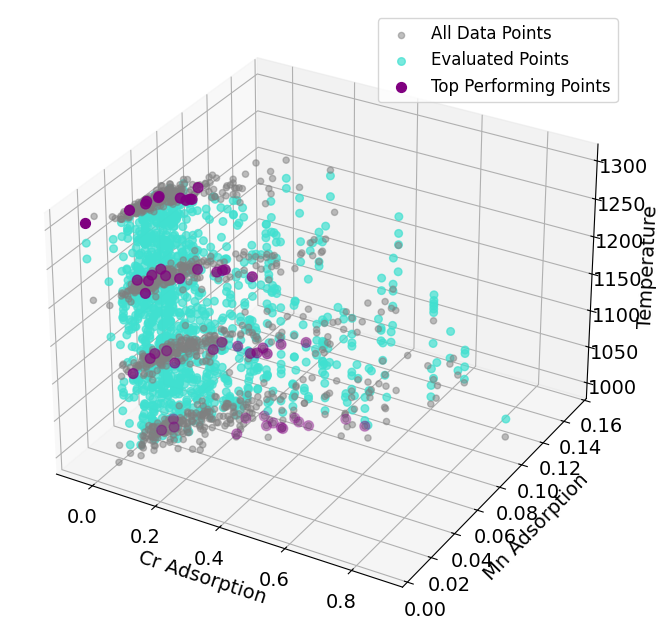

In [1]:
import numpy as np
import pandas as pd
from skopt.space import Real
from skopt.learning import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Step 1: Load the data
file_path = 'C:/Users/sdas15/OneDrive - The University of Alabama/Fall_25/GitHub/Min_Segregation/ANN_data.csv'
data = pd.read_csv(file_path, header=1)

# Features (compositions and temperature)
X = data[['Co_comp', 'Ni_comp', 'Cr_comp', 'Fe_comp', 'Mn_comp', 'Temp']]

# Define the target columns for maximization and minimization
cr_adsorption = data['Cr_adsorption']  # Miniimize
mn_adsorption = data['Mn_adsorption']  # Miniimize
co_adsorption = data['Co_adsorption']  # Maximize
ni_adsorption = data['Ni_adsorption']  # Maximize
fe_adsorption = data['Fe_adsorption']  # Maximize
temp = data['Temp']  # Temperature column properly defined here

# Step 2: Define the search space for Bayesian Optimization
search_space = [
    Real(X['Co_comp'].min(), X['Co_comp'].max(), name='Co_comp'),
    Real(X['Ni_comp'].min(), X['Ni_comp'].max(), name='Ni_comp'),
    Real(X['Cr_comp'].min(), X['Cr_comp'].max(), name='Cr_comp'),
    Real(X['Fe_comp'].min(), X['Fe_comp'].max(), name='Fe_comp'),
    Real(X['Temp'].min(), X['Temp'].max(), name='Temp')  # Temperature is independent of compositions
]

np.random.seed(44)

# Step 3: Define the objective function (minimize Cr/Mn, maximize Co/Ni/Fe)
def objective(params):
    Co_comp, Ni_comp, Cr_comp, Fe_comp, Temp = params
    
    # Calculate Mn_comp as the remaining part to ensure the sum equals 1
    Mn_comp = 1 - (Co_comp + Ni_comp + Cr_comp + Fe_comp)
    
    # If Mn_comp is negative, return a penalty as the solution is invalid
    if Mn_comp < 0:
        return np.inf, None  # Also return None for uncertainty
    
    # Create a DataFrame with the current parameters
    current_params = pd.DataFrame([[Co_comp, Ni_comp, Cr_comp, Fe_comp, Mn_comp, Temp]],
                                  columns=['Co_comp', 'Ni_comp', 'Cr_comp', 'Fe_comp', 'Mn_comp', 'Temp'])
    
    # Find the closest point in the data
    closest_index = np.argmin(np.sum((X[['Co_comp', 'Ni_comp', 'Cr_comp', 'Fe_comp', 'Mn_comp', 'Temp']] - current_params.values)**2, axis=1))
    
    # Retrieve the adsorption values at the closest index
    cr_value = cr_adsorption.iloc[closest_index]
    mn_value = mn_adsorption.iloc[closest_index]
    co_value = co_adsorption.iloc[closest_index]
    ni_value = ni_adsorption.iloc[closest_index]
    fe_value = fe_adsorption.iloc[closest_index]
    
    # Combine the objectives: minimize Cr and Mn, maximize Co, Ni, Fe
    score = (cr_value + mn_value) - (co_value + ni_value + fe_value)
       
    # Uncertainty estimate: let's use the standard deviation from the Gaussian process
    return score, None  # Second value (None) will later be used for uncertainty

# Step 4: Set up Thompson Sampling for Bayesian Optimization
kernel = C(1.0, (1e-5, 1e3)) * RBF(1.0, (1e-2, 1e2))
gp_model = GaussianProcessRegressor(kernel=kernel, random_state=42)

# Implement Thompson Sampling
def thompson_sampling_acquisition(model, X_samples):
    """
    Function to perform Thompson Sampling: sample a function from the GP posterior
    and evaluate it at the candidate points X_samples.
    """
    # Predict the mean and covariance of the GP at the sample points
    mu, cov = model.predict(X_samples, return_cov=True)
    
    # Sample from the posterior
    samples = np.random.multivariate_normal(mu, cov)
    
    # Return the index of the sample that maximizes the sampled function
    return np.argmax(samples), np.sqrt(np.diag(cov))  # Returning uncertainty (stddev)

# Step 5: Thompson Sampling Loop
n_iterations = 2000
best_score = np.inf
best_params = None
uncertainty_list = []

# Lists to store evaluated points
evaluated_cr_adsorption = []
evaluated_mn_adsorption = []
evaluated_temperature = []

for iteration in range(n_iterations):
    # Sample candidate points from the search space
    X_samples = np.random.rand(700, len(search_space))  # 700 random points to sample from
    
    # Transform the random samples to the search space dimensions
    for i, dim in enumerate(search_space):
        X_samples[:, i] = X_samples[:, i] * (dim.high - dim.low) + dim.low
    
    # Use Thompson Sampling to select the next point
    next_point_idx, uncertainties = thompson_sampling_acquisition(gp_model, X_samples)
    next_point = X_samples[next_point_idx]
    
    # Extract individual parameters from the sampled point
    Co_comp, Ni_comp, Cr_comp, Fe_comp, Temp = next_point
    
    # Evaluate the objective function at the selected point
    score, uncertainty = objective(next_point)
    
    # Only update the GP model if the score is valid (not np.inf)
    if score != np.inf:
        gp_model.fit(np.array([next_point]), np.array([score]))
        
        # Update the best solution found
        if score < best_score:
            best_score = score
            best_params = next_point
            best_uncertainty = uncertainties[next_point_idx]  # Keep track of the uncertainty
        
        # Calculate Mn_comp as the remaining composition
        Mn_comp = 1 - (Co_comp + Ni_comp + Cr_comp + Fe_comp)
        current_params = pd.DataFrame([[Co_comp, Ni_comp, Cr_comp, Fe_comp, Mn_comp, Temp]],
                                      columns=['Co_comp', 'Ni_comp', 'Cr_comp', 'Fe_comp', 'Mn_comp', 'Temp'])
        
        # Find the closest index to the evaluated parameters
        closest_index = np.argmin(np.sum((X[['Co_comp', 'Ni_comp', 'Cr_comp', 'Fe_comp', 'Mn_comp', 'Temp']] - current_params.values)**2, axis=1))
        
        # Append the evaluated adsorption values and temperature for plotting
        evaluated_cr_adsorption.append(cr_adsorption.iloc[closest_index])
        evaluated_mn_adsorption.append(mn_adsorption.iloc[closest_index])
        evaluated_temperature.append(Temp)  # Append the actual temperature from the sampled point

        # Keep a log of uncertainties across iterations
        uncertainty_list.append(best_uncertainty)

# Calculate Mn_comp based on the best params
best_params = list(best_params)
best_params.append(1 - sum(best_params[:4]))  # Mn_comp = 1 - (Co + Ni + Cr + Fe)

# Ensure that temperature and Mn_comp are correct
optimal_temp = best_params[4]  # This is the temperature
best_params[4] = best_params[5]  # Assign Mn_comp correctly
best_params[5] = optimal_temp  # Reassign Temp to the correct position

print(f"Optimal Composition and Temperature: {best_params}")
print(f"Optimal Combined Score (Cr/Mn minimized, Co/Ni/Fe maximized): {best_score}")
print(f"Uncertainty in the Best Prediction: {best_uncertainty}")

# Recalculate Mn_comp to complete the composition
Mn_comp = 1 - sum(best_params[:4])

# Create a DataFrame for the optimal composition
optimal_input = pd.DataFrame([[best_params[0], best_params[1], best_params[2], best_params[3], Mn_comp, best_params[5]]],
                             columns=['Co_comp', 'Ni_comp', 'Cr_comp', 'Fe_comp', 'Mn_comp', 'Temp'])

# Find the closest match in the dataset
closest_index = np.argmin(np.sum((X[['Co_comp', 'Ni_comp', 'Cr_comp', 'Fe_comp', 'Mn_comp', 'Temp']] - optimal_input.values)**2, axis=1))

# Extract adsorption values at this point
cr_at_opt = cr_adsorption.iloc[closest_index]
mn_at_opt = mn_adsorption.iloc[closest_index]

print(f"Cr adsorption at optimal composition: {cr_at_opt}")
print(f"Mn adsorption at optimal composition: {mn_at_opt}")


# Convert the result into a DataFrame for better readability
optimal_composition = pd.DataFrame([best_params], columns=['Co_comp', 'Ni_comp', 'Cr_comp', 'Fe_comp', 'Mn_comp', 'Temp'])
print(f"Optimal Composition for Desired Adsorption:\n{optimal_composition}")

# Identify points closest to the optimal composition found by the optimization
distances = np.sqrt((data['Co_comp'] - best_params[0])**2 +
                    (data['Ni_comp'] - best_params[1])**2 +
                    (data['Cr_comp'] - best_params[2])**2 +
                    (data['Fe_comp'] - best_params[3])**2 +
                    (data['Mn_comp'] - best_params[4])**2)

# Define a threshold to classify top-performing points (e.g., top 5% closest points)
threshold = np.percentile(distances, 5)  # Top 5% closest points
optimal_points = distances <= threshold

# Step 6: Create a 3D scatter plot
top_performing_df = pd.DataFrame({
    'Co_comp': X['Co_comp'][optimal_points].values,
    'Ni_comp': X['Ni_comp'][optimal_points].values,
    'Cr_comp': X['Cr_comp'][optimal_points].values,
    'Fe_comp': X['Fe_comp'][optimal_points].values,
    'Mn_comp': X['Mn_comp'][optimal_points].values,
    'Temp': temp[optimal_points].values
})
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot all data points in grey
ax.scatter(cr_adsorption, mn_adsorption, temp, color='grey', alpha=0.5, s=20, label='All Data Points')

# Highlight the evaluated points in turquoise (those sampled during Thompson Sampling)
ax.scatter(evaluated_cr_adsorption, evaluated_mn_adsorption, evaluated_temperature,
           color='turquoise', s=30, label='Evaluated Points', alpha=0.7)

# Highlight the best points (or closest to optimal composition) in purple
ax.scatter(cr_adsorption[optimal_points], mn_adsorption[optimal_points], temp[optimal_points],
           color='purple', s=50, label='Top Performing Points', depthshade=True)

# Step 7: Label the axes
ax.set_xlabel('Cr Adsorption', fontsize = 14)
ax.set_ylabel('Mn Adsorption', fontsize = 14)
ax.set_zlabel('Temperature', fontsize = 14)

# Adjust tick size for all axes
ax.tick_params(axis='x', labelsize=14)  # Increase font size for x-axis ticks
ax.tick_params(axis='y', labelsize=14)  # Increase font size for y-axis ticks
ax.tick_params(axis='z', labelsize=14)  # Increase font size for z-axis ticks


# Step 8: Add a title and legend
#ax.set_title('Performance Space Optimization')
ax.legend(fontsize = 12)

# Show plot
plt.show()
# Save the plot in high quality
fig.savefig('performance_space_optimization.png', dpi=300)  # Save as PNG with 300 dpi for high resolution
fig.savefig('performance_space_optimization.jpg', dpi=300)  # Save as JPG with 300 dpi for high resolution
fig.savefig('performance_space_optimization.pdf', dpi=300)  # Save as PDF for vector graphics



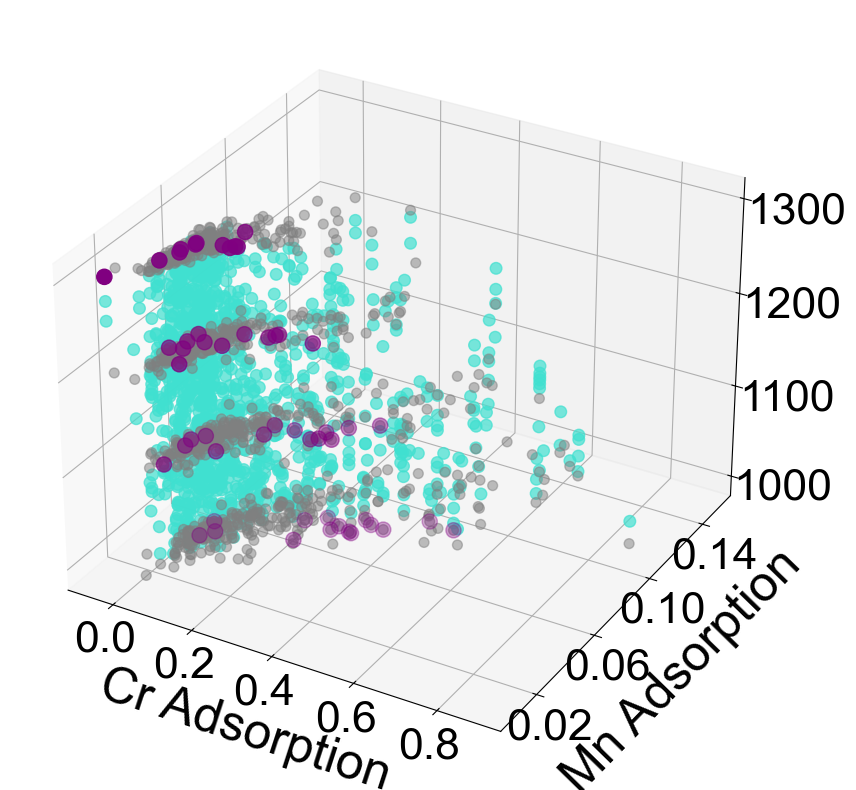

In [2]:
plt.rcParams['font.family'] = 'Arial'

# Step 6: Create a 3D scatter plot
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot all data points in grey
ax.scatter(cr_adsorption, mn_adsorption, temp, color='grey', alpha=0.5, s=50, label='All Data Points')

# Highlight the evaluated points in turquoise (those sampled during Thompson Sampling)
ax.scatter(evaluated_cr_adsorption, evaluated_mn_adsorption, evaluated_temperature,
           color='turquoise', s=70, label='Evaluated Points', alpha=0.7)

# Highlight the best points (or closest to optimal composition) in purple
ax.scatter(cr_adsorption[optimal_points], mn_adsorption[optimal_points], temp[optimal_points],
           color='purple', s=120, label='Top Performing Points', depthshade=True)

# Step 7: Label the axes
ax.set_xlabel('Cr Adsorption', fontsize=36, labelpad=16)
ax.set_ylabel('Mn Adsorption', fontsize=36, labelpad=20)
#ax.set_zlabel('Temperature', fontsize=32, labelpad=25)


# Adjust tick size for all axes
ax.tick_params(axis='x', labelsize=32)  # Increase font size for x-axis ticks
ax.tick_params(axis='y', labelsize=32)  # Increase font size for y-axis ticks
ax.tick_params(axis='z', labelsize=32)  # Increase font size for z-axis ticks

ax.zaxis.set_tick_params(pad=15) 
ax.yaxis.set_tick_params(pad=0.5) 
ax.xaxis.set_tick_params(pad=0.5)

ax.set_xticks([0.0, 0.2, 0.4, 0.6, 0.8])  # Example ticks for Cr Adsorption
ax.set_yticks([0.02, 0.06, 0.10, 0.14])    # Example ticks for Mn Adsorption
ax.set_zticks([1000, 1100, 1200, 1300])    # Example ticks for Temperature


# Step 8: Add a title and legend
#ax.set_title('Performance Space Optimization')
# Step 8: Add a title and legend
#ax.set_title('Performance Space Optimization', fontsize=16, pad=20)

# Customize the legend with increased font size and marker sizes
#legend = ax.legend(
    #fontsize=22,              # Increase font size of the legend text
    #loc='best',               # Automatically place the legend in the best location
    #markerscale=1.3           # Scale up the size of the balls (markers) in the legend
#)
#legend.get_frame().set_alpha(0.9)  # Make the legend background slightly transparent


# Show plot
plt.show()
# Save the plot in high quality
fig.savefig('performance_space_optimization_updated.png', dpi=300)  # Save as PNG with 300 dpi for high resolution
fig.savefig('performance_space_optimization_updated.jpg', dpi=300)  # Save as JPG with 300 dpi for high resolution
fig.savefig('performance_space_optimization_updated.pdf', dpi=300)  # Save as PDF for vector graphics

In [3]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
from sklearn.cluster import KMeans

plt.rcParams['font.family'] = 'Arial'


# Step 1: Prepare the top-performing points DataFrame
top_performing_df = pd.DataFrame({
    'Co_comp': co_adsorption[optimal_points],
    'Ni_comp': ni_adsorption[optimal_points],
    'Cr_comp': cr_adsorption[optimal_points],
    'Fe_comp': fe_adsorption[optimal_points],
    'Mn_comp': mn_adsorption[optimal_points],
    'Temp': temp[optimal_points]
})

# Step 2: Perform KMeans clustering for the scatter plot based on Cr, Mn, and Temp
scatter_features = top_performing_df[['Cr_comp', 'Mn_comp', 'Temp']]
n_clusters = 4
kmeans_scatter = KMeans(n_clusters=n_clusters, random_state=42)
top_performing_df['Region_Scatter'] = kmeans_scatter.fit_predict(scatter_features)

# Define darker colors for each cluster (region)
cluster_colors = ['#228B22', '#00008B', '#DC143C', '#FFC300']  # Dark Red, Dark Blue, Dark Green, Gold

# Step 3: Loop through each cluster and save each plot as a separate PNG file
for i in range(n_clusters):
    fig = plt.figure(figsize=(14, 14))  # Adjust figure size for individual plots
    ax = fig.add_subplot(1, 1, 1, projection='3d')
    ax.scatter(top_performing_df['Cr_comp'], top_performing_df['Mn_comp'], top_performing_df['Temp'], 
               c='darkgrey', s=700, depthshade=True, alpha=0.4)  # Darker grey for background points
    
    scatter_cluster_points = top_performing_df[top_performing_df['Region_Scatter'] == i]
    ax.scatter(scatter_cluster_points['Cr_comp'], scatter_cluster_points['Mn_comp'], scatter_cluster_points['Temp'], 
               color=cluster_colors[i], s=1000, depthshade=True, alpha=1, label=f'Scatter Region {i+1}')  # Darker, larger points
    
    # Set axis labels with font size
    #ax.set_xlabel('Cr Adsorption', fontsize=65, labelpad=39, rotation = 120)
    #ax.set_ylabel('Mn Adsorption', fontsize=65, labelpad=31, rotation = 280)
    # Adjust label alignment
    #ax.yaxis.label.set_horizontalalignment('left')  # Move label left
    #ax.yaxis.label.set_verticalalignment('center')  # Center vertically
    plt.tight_layout()
    #ax.set_zlabel('Temperature (K)', fontsize=50, labelpad=15)
    
    # Adjust tick font size and reduce tick density
    ax.zaxis.set_tick_params(pad=40) 
    ax.yaxis.set_tick_params(pad=20)  # Add extra padding for y-axis tick labels
    ax.xaxis.set_tick_params(pad=20) # Add extra padding for y-axis tick labels
    ax.tick_params(axis='x', labelsize=20)
    ax.tick_params(axis='y', labelsize=20)
    ax.tick_params(axis='z', labelsize=20)
    ax.set_xticks([0.0, 0.2, 0.4, 0.6, 0.8])  # Example ticks for Cr Adsorption
    ax.set_yticks([0.02, 0.06, 0.10, 0.14])    # Example ticks for Mn Adsorption
    ax.set_zticks([1000, 1100, 1200, 1300])    # Example ticks for Temperature

    ax.view_init(elev=20, azim=257)
    
    # Save each plot with a unique filename
    plt.tight_layout()
    filename = f'scatter_plot_region_{i+1}.png'
    plt.savefig(filename, dpi=600, bbox_inches="tight")  # Save individual scatter plot
    plt.close(fig)  # Close the figure to save memory


Violin Cluster Centers (Co_comp, Ni_comp, Cr_comp, Fe_comp, Mn_comp, Temp):
[[3.55945413e-01 1.85171333e-01 1.97180213e-01 1.60175293e-01
  1.01527761e-01 1.00000000e+03]
 [3.50429182e-01 2.04938127e-01 1.96837709e-01 1.44833262e-01
  1.02961615e-01 1.30000000e+03]
 [3.53019529e-01 1.93440814e-01 1.98181729e-01 1.54109329e-01
  1.01248579e-01 1.10000000e+03]
 [3.53844250e-01 2.00392917e-01 1.95219417e-01 1.45491027e-01
  1.05052507e-01 1.20000000e+03]]


C:\Users\sdas15\AppData\Local\Temp\ipykernel_34976\935797868.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Element', y='Concentration', data=melted_df, ax=ax_violin, palette=[cluster_colors[i]])
C:\Users\sdas15\AppData\Local\Temp\ipykernel_34976\935797868.py:46: UserWarning: 
The palette list has fewer values (1) than needed (5) and will cycle, which may produce an uninterpretable plot.
  sns.violinplot(x='Element', y='Concentration', data=melted_df, ax=ax_violin, palette=[cluster_colors[i]])
C:\Users\sdas15\AppData\Local\Temp\ipykernel_34976\935797868.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Element', y='Concentration', data=melted_df, ax=ax_violin, palette=

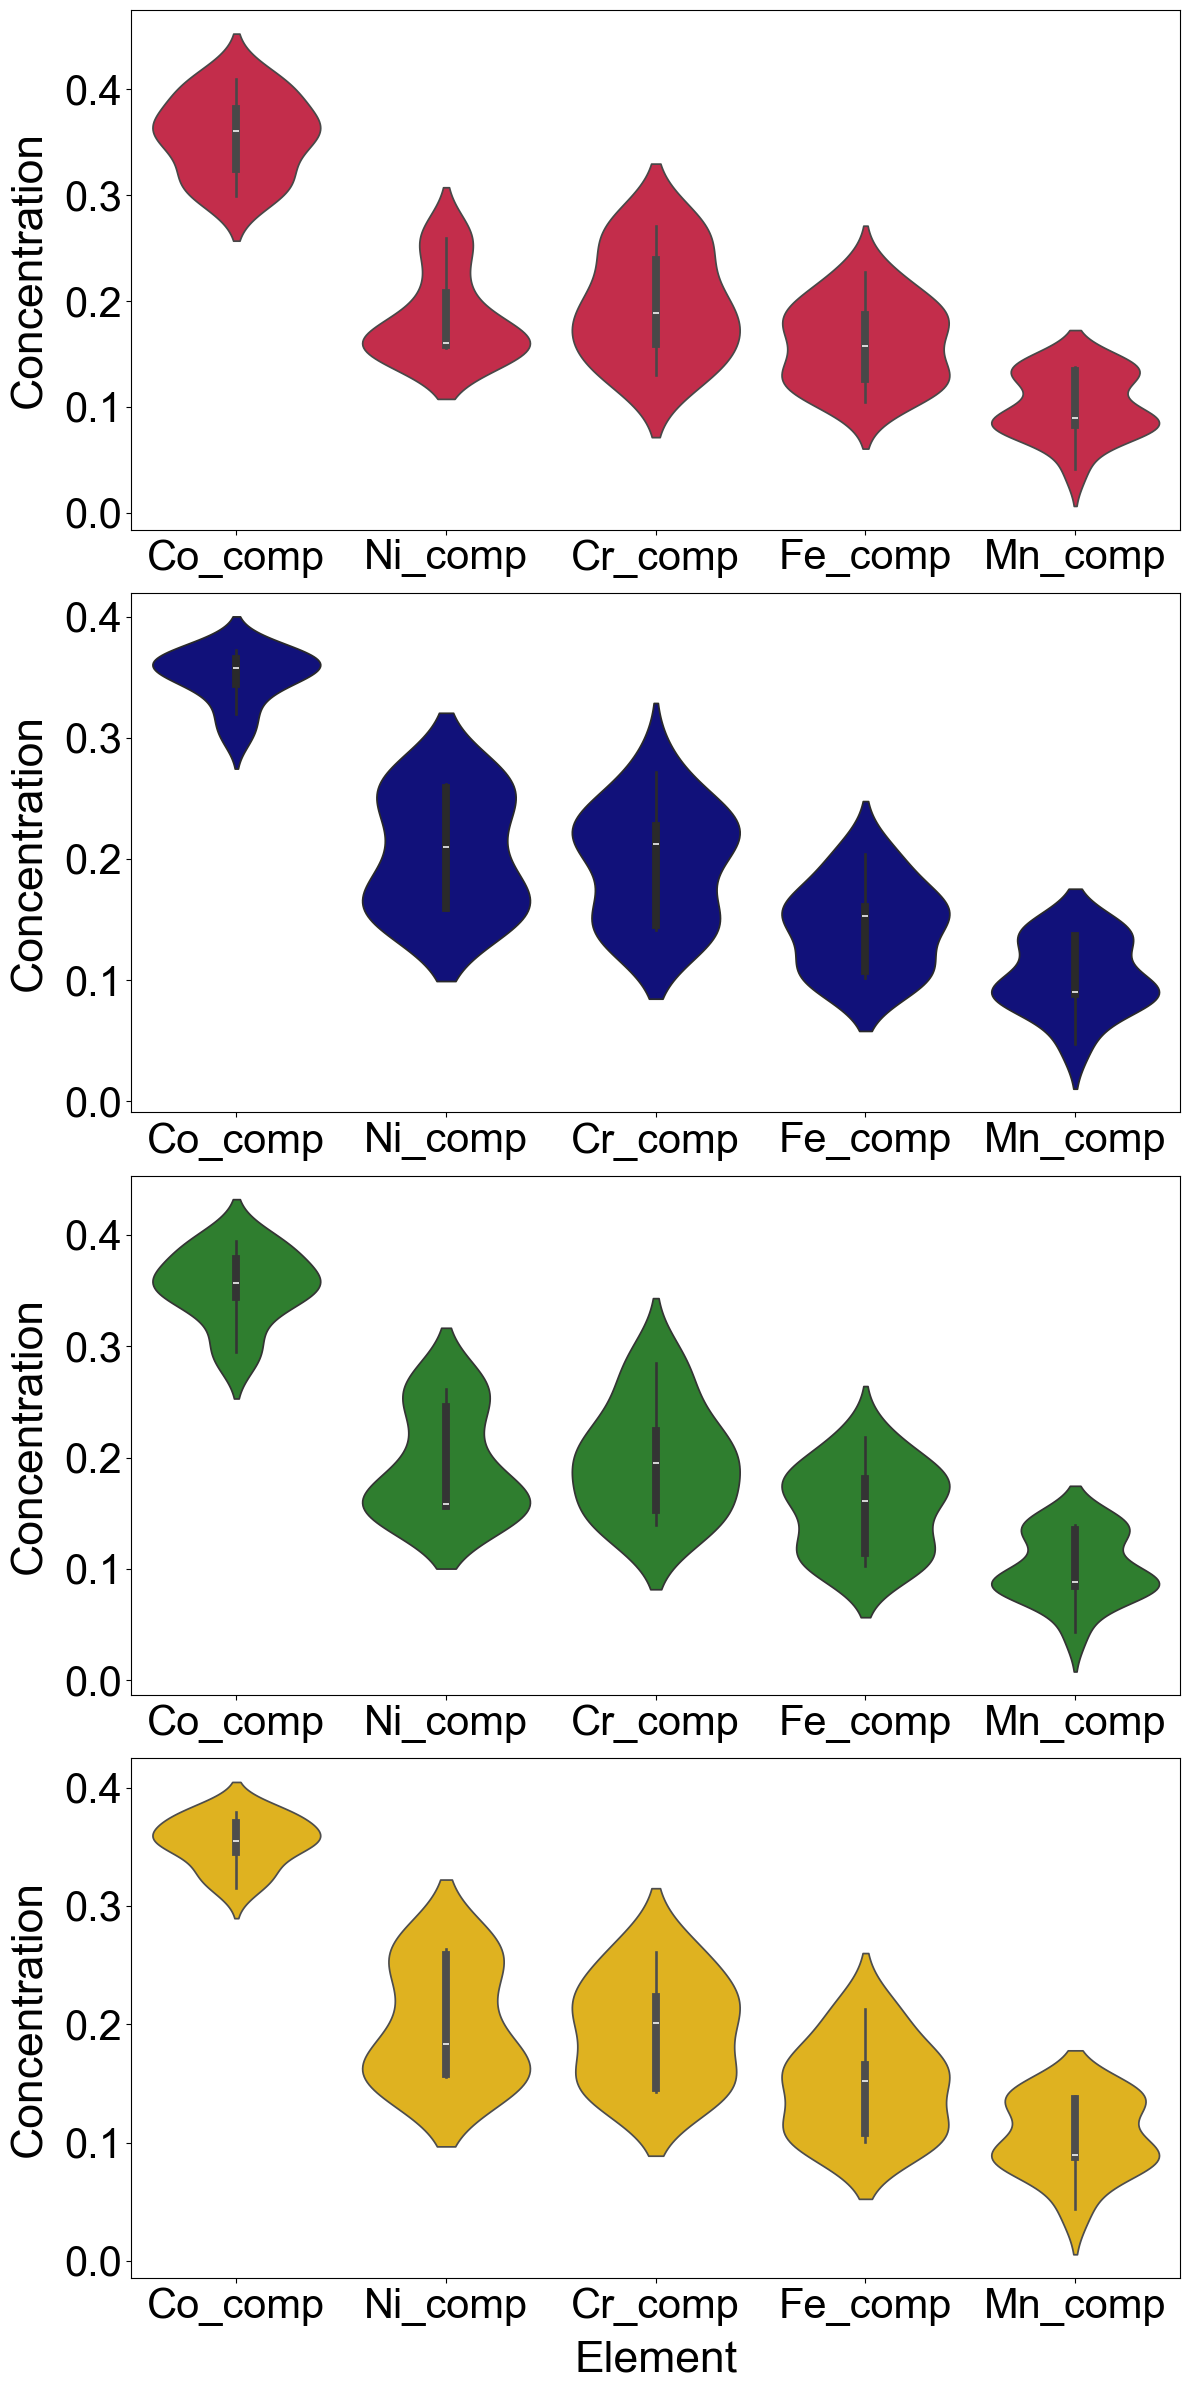

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.gridspec as gridspec

plt.rcParams['font.family'] = 'Arial'

# Step 1: Use the top-performing points from the second code (Thompson Sampling)
top_performing_df = pd.DataFrame({
    'Co_comp': X['Co_comp'][optimal_points].values,
    'Ni_comp': X['Ni_comp'][optimal_points].values,
    'Cr_comp': X['Cr_comp'][optimal_points].values,
    'Fe_comp': X['Fe_comp'][optimal_points].values,
    'Mn_comp': X['Mn_comp'][optimal_points].values,
    'Temp': X['Temp'][optimal_points].values
})

# Step 2: Perform clustering for the violin plots based on all features (Co, Ni, Cr, Fe, Mn, Temp)
violin_features = top_performing_df[['Co_comp', 'Ni_comp', 'Cr_comp', 'Fe_comp', 'Mn_comp', 'Temp']]
n_clusters = 4
kmeans_violin = KMeans(n_clusters=n_clusters, random_state=42)
top_performing_df['Region_Violin'] = kmeans_violin.fit_predict(violin_features)

# Print cluster centers for violin clustering
print(f"Violin Cluster Centers (Co_comp, Ni_comp, Cr_comp, Fe_comp, Mn_comp, Temp):\n{kmeans_violin.cluster_centers_}")

# Step 3: Create the figure layout for violin plots only (clustered by all elements)
fig = plt.figure(figsize=(12, 24))  # Increased figure size for better clarity
gs = gridspec.GridSpec(4, 1, height_ratios=[1, 1, 1, 1])  # Only one column for the violin plots

# Define colors for each cluster
cluster_colors = ['#DC143C', '#00008B', '#228B22', '#FFC300']

# Step 4: Loop through each cluster and create violin plots
for i in range(n_clusters):
    # Violin plot (Clustered by all elements)
    ax_violin = fig.add_subplot(gs[i, 0])
    
    # Get points corresponding to the current violin cluster
    violin_cluster_points = top_performing_df[top_performing_df['Region_Violin'] == i]
    melted_df = pd.melt(violin_cluster_points, id_vars='Region_Violin', 
                        value_vars=['Co_comp', 'Ni_comp', 'Cr_comp', 'Fe_comp', 'Mn_comp'], 
                        var_name='Element', value_name='Concentration')
    
    sns.violinplot(x='Element', y='Concentration', data=melted_df, ax=ax_violin, palette=[cluster_colors[i]])
    
    # Customize axis labels, title, and ticks
    if i == n_clusters - 1:  # Only set the x-label for the last panel
        ax_violin.set_xlabel('Element', fontsize=32, labelpad=10)
    else:
        ax_violin.set_xlabel('')  # Remove the x-label for other panels
    ax_violin.set_ylabel('Concentration', fontsize=32, labelpad=10)
    ax_violin.tick_params(axis='x', labelsize=30)
    ax_violin.tick_params(axis='y', labelsize=30)

# Adjust layout to fit the plots
plt.tight_layout()
plt.show()

# Save the final violin plot only
fig.savefig('violin_plots_with_single_xlabel.png', dpi=300)
